<a href="https://colab.research.google.com/github/Rajagopalhertzian/Cargame-using-pygame/blob/main/Dog_breed_identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import files
files.upload()  # Choose your kaggle.json file here

# Move kaggle.json to the correct directory and set permissions
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#  Download the Dog Breed Identification dataset from Kaggle
!kaggle competitions download -c dog-breed-identification



!unzip dog-breed-identification.zip -d ./dog_breed_dataset

Streaming output truncated to the last 5000 lines.
  inflating: ./dog_breed_dataset/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: ./dog_breed_dataset/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: ./dog_breed_dataset/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: ./dog_breed_dataset/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: ./dog_breed_dataset/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: ./dog_breed_dataset/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: ./dog_breed_dataset/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: ./dog_breed_dataset/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: ./dog_breed_dataset/train/83fad0718581a696132c96c166472627.jpg  
  inflating: ./dog_breed_dataset/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: ./dog_breed_dataset/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: ./dog_breed_dataset/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: 

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import os

# Define dataset paths
train_dir = './dog_breed_dataset/train'
labels_file = './dog_breed_dataset/labels.csv'

# Step 6: Data Preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Step 7: Define Custom Dataset Class
class DogBreedDataset(Dataset):
    def __init__(self, img_dir, labels_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.labels = self._load_labels(labels_file)

    def _load_labels(self, labels_file):
        import pandas as pd
        df = pd.read_csv(labels_file)
        label_dict = {label: idx for idx, label in enumerate(df['breed'].unique())}
        df['label'] = df['breed'].map(label_dict)
        return df

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        row = self.labels.iloc[idx]
        img_path = os.path.join(self.img_dir, row['id'] + '.jpg')
        image = Image.open(img_path).convert('RGB')
        label = row['label']
        if self.transform:
            image = self.transform(image)
        return image, label

# Load Dataset
train_dataset = DogBreedDataset(train_dir, labels_file, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Step 8: Model Setup (Transfer Learning with ResNet50)
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 120)  # 120 dog breeds

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 9: Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(5):  # Train for 5 epochs
    model.train()
    running_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}')

# Save the trained model
torch.save(model.state_dict(), 'dog_breed_model.pth')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 157MB/s]


Epoch 1, Loss: 4.802034248411656
Epoch 2, Loss: 4.648864732682705
Epoch 3, Loss: 4.458652870357037
Epoch 4, Loss: 4.325001008063555
Epoch 5, Loss: 4.119736306369305


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def predict_breed(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Move input to GPU
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    return train_dataset.labels['breed'].unique()[predicted.item()]

print(predict_breed('/content/dog_breed_dataset/test/000621fb3cbb32d8935728e48679680e.jpg'))

brittany_spaniel


In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def predict_breed(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)  # Move input to GPU
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    return train_dataset.labels['breed'].unique()[predicted.item()]

print(predict_breed('/content/dog_breed_dataset/test/13b4953cc9afdcf603692f74a7cf8048.jpg'))

keeshond


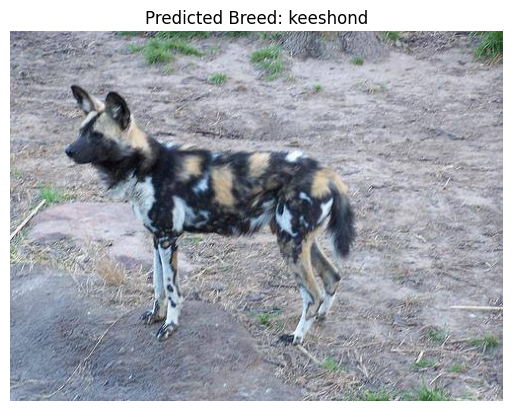

keeshond


In [ ]:
import torch
from PIL import Image
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

def predict_breed(image_path):
    image = Image.open(image_path).convert('RGB')
    transformed_image = transform(image).unsqueeze(0).to(device)  # Apply transformations and move to GPU
    with torch.no_grad():
        output = model(transformed_image)
        _, predicted = torch.max(output, 1)
    breed = train_dataset.labels['breed'].unique()[predicted.item()]

    # Display the image with the predicted breed
    plt.imshow(image)
    plt.title(f"Predicted Breed: {breed}")
    plt.axis('off')
    plt.show()

    return breed

# Predict and display
print(predict_breed('/content/dog_breed_dataset/test/13b4953cc9afdcf603692f74a7cf8048.jpg'))

In [ ]:
class_names = train_dataset.labels['breed'].unique()
print(class_names)

['boston_bull' 'dingo' 'pekinese' 'bluetick' 'golden_retriever'
 'bedlington_terrier' 'borzoi' 'basenji' 'scottish_deerhound'
 'shetland_sheepdog' 'walker_hound' 'maltese_dog' 'norfolk_terrier'
 'african_hunting_dog' 'wire-haired_fox_terrier' 'redbone'
 'lakeland_terrier' 'boxer' 'doberman' 'otterhound' 'standard_schnauzer'
 'irish_water_spaniel' 'black-and-tan_coonhound' 'cairn' 'affenpinscher'
 'labrador_retriever' 'ibizan_hound' 'english_setter' 'weimaraner'
 'giant_schnauzer' 'groenendael' 'dhole' 'toy_poodle' 'border_terrier'
 'tibetan_terrier' 'norwegian_elkhound' 'shih-tzu' 'irish_terrier'
 'kuvasz' 'german_shepherd' 'greater_swiss_mountain_dog' 'basset'
 'australian_terrier' 'schipperke' 'rhodesian_ridgeback' 'irish_setter'
 'appenzeller' 'bloodhound' 'samoyed' 'miniature_schnauzer'
 'brittany_spaniel' 'kelpie' 'papillon' 'border_collie' 'entlebucher'
 'collie' 'malamute' 'welsh_springer_spaniel' 'chihuahua' 'saluki' 'pug'
 'malinois' 'komondor' 'airedale' 'leonberg' 'mexican_h

In [ ]:
# Define dataset path for test data
test_dir = './dog_breed_dataset/train'
test_labels_file = './dog_breed_dataset/labels.csv'

# Create test dataset and DataLoader
test_dataset = DogBreedDataset(test_dir, test_labels_file, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
model.eval()  # Set the model to evaluation mode
all_preds, all_labels = [], []

with torch.no_grad():  # Disable gradient computation for inference
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(all_labels, all_preds)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.08276266875366856
